In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

%run ../DDELFI.py

import scipy as sp

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from delfi.simulator import Gauss

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib inline

In [2]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=False) / self.b.eval(samples, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
class MultipliedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, ii=None, log=True):
        ret = self.a.eval(samples, ii=ii, log=False) * self.b.eval(samples, ii=ii, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

def multiply_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a * b
    
    return MultipliedPdf(a, b, norm_region)

In [3]:
class BimodalGaussian(BaseSimulator):
    def __init__(self, slope, noise_var, seed = None):
        super().__init__(dim_param=1, seed=seed)
        self.slope = slope
        self.noise_var = noise_var
        
    def gen_single(self, params):
        dist = self.get_likelihood(params)
        sample = dist.gen(1).reshape(-1)
        return { 'data' : sample }
    
    def get_likelihood(self, params):
        return dd.MoG(a=[0.5, 0.5], ms=[self.slope * params, -self.slope * params], Ss = 2 * [np.eye(1) * self.noise_var])

In [4]:
def run_panel(algo, params, seed=None):
    if seed is None:
        seed = params.seed
        
    m = BimodalGaussian(params.slope, params.noise_cov, seed=seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=params.prior, summary=s)
    
    kws = { 'generator' : g,
            'obs' : [params.obs_stats],
            'n_hiddens' : params.n_hiddens,
            'seed' : seed,
            'verbose' : True,
            'reinit_weights' : True,
            'svi' : False }
    
    run_kws = {}
    if algo == 'DDELFI':
        res = DDELFI(**kws, prior_mixin=0.1)
    elif algo == 'SNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000 }
    elif algo == 'kSNPE':
        res = infer.SNPE(**kws, convert_to_T=3)
        run_kwargs = { 'round_cl' : 1000, 'kernel_loss' : 'x_kl' }
    elif algo == 'CDELFI':
        res = infer.CDELFI(**kws)
    else:
        raise NotImplemented("Unknown algorithm")
    
    ret = res.run(n_train=params.n_train, n_rounds = params.n_rounds, **run_kws)

    posteriors = ret[2]
    return posteriors

In [20]:
params = ParameterSet({})

params.seed = 399
params.n_hiddens = [ 20 ] * 2

params.noise_cov = 0.3

params.n_train = 500
params.n_rounds = 3

params.prior_width = 5

params.n_runs = 50

params.slope = 1

params.true_params = np.array([ 3 ])

In [21]:
params.prior = dd.Uniform(lower=-params.prior_width, upper=params.prior_width)

params.obs_stats = params.true_params * params.slope

params.gt = dd.MoG(a=[0.5,0.5], ms=[params.obs_stats / params.slope, -params.obs_stats / params.slope], 
                   Ss = 2 * [np.eye(1) * params.noise_cov])

In [22]:
COL = { 'DDELFI' : 'orange', 'SNPE' : 'r', 'kSNPE' : 'g', 'CDELFI' : 'k' }

In [23]:
def plot_row(data):
    plt.figure(figsize=(16,5))
    
    algos = data.keys()
    
    xlist = np.linspace(-params.prior_width, params.prior_width, 200)
    
    for i, algo in enumerate(algos):
        plt.subplot(1, len(algos), i + 1)
        
        for posterior in data[algo]:
            if posterior is not None:
                ylist = posterior.eval(xlist.reshape(-1,1), log=False)
                ls = '--'

                if posterior == data[algo][-1]:
                    ls = None

                plt.plot(xlist, ylist, color=COL[algo], linewidth=2, ls=ls)
                
        ax = plt.gca()
        ax.set_title(algo)
        ax.set_yticks([])
        ax.axvline(params.true_params, color='gray', ls='--')
        plt.xticks([params.true_params], ['$x_o$'])
            
        plt.legend()
        
    plt.show()
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40017056]: : 18it [00:00, 101.55it/s]

loss=[ 2.3949244]: : 1347it [00:07, 169.97it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41170502]: : 16it [00:00, 92.67it/s] 

loss=[ 2.41147876]: : 1090it [00:07, 147.35it/s]


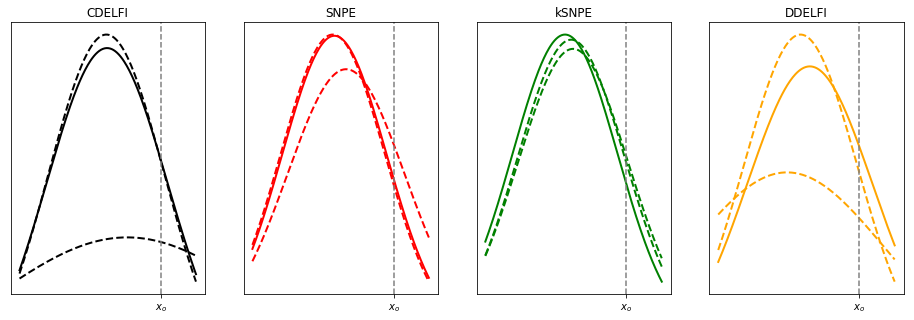

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42570257]: : 18it [00:00, 101.46it/s]

loss=[ 2.41878295]: : 1556it [00:10, 153.19it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.46063757]: : 15it [00:00, 91.55it/s] 

loss=[ 2.46050692]: : 1068it [00:07, 151.27it/s]


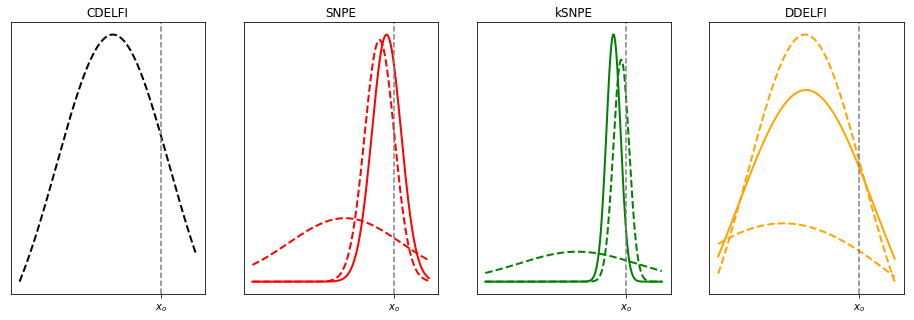

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44717956]: : 18it [00:00, 100.53it/s]

loss=[ 2.43853974]: : 3206it [00:22, 142.83it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4209621]: : 17it [00:00, 103.19it/s] 

loss=[ 2.42064762]: : 1050it [00:06, 171.86it/s]


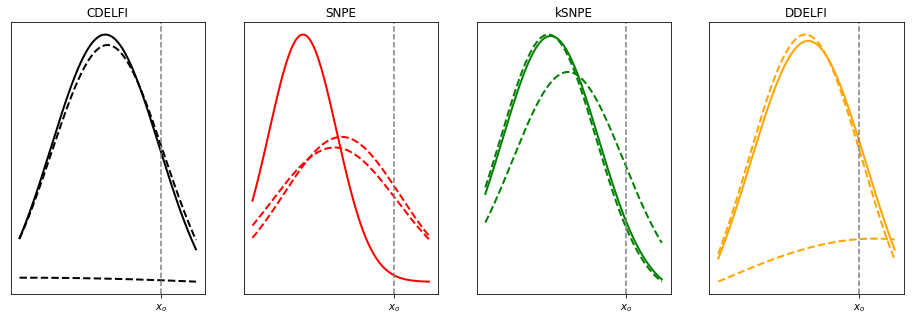

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4315424]: : 17it [00:00, 97.11it/s]  

loss=[ 2.4231894]: : 1949it [00:11, 174.98it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42964888]: : 18it [00:00, 109.13it/s]

loss=[ 2.42962432]: : 1062it [00:06, 167.26it/s]


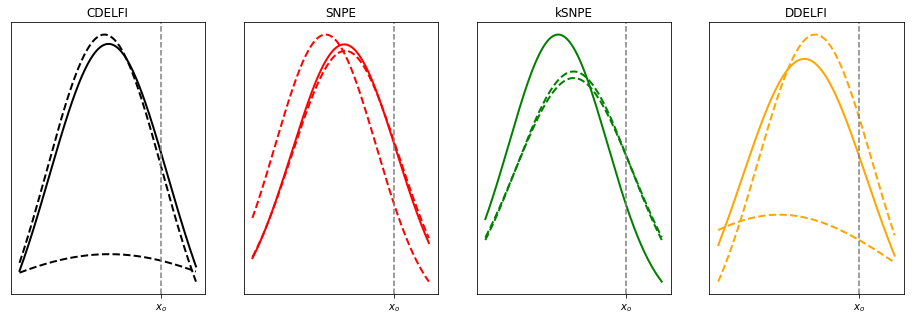

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42758441]: : 17it [00:00, 95.84it/s] 

loss=[ 2.41834688]: : 2395it [00:13, 177.47it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43130088]: : 20it [00:00, 119.30it/s]

loss=[ 2.43050647]: : 1079it [00:06, 168.10it/s]


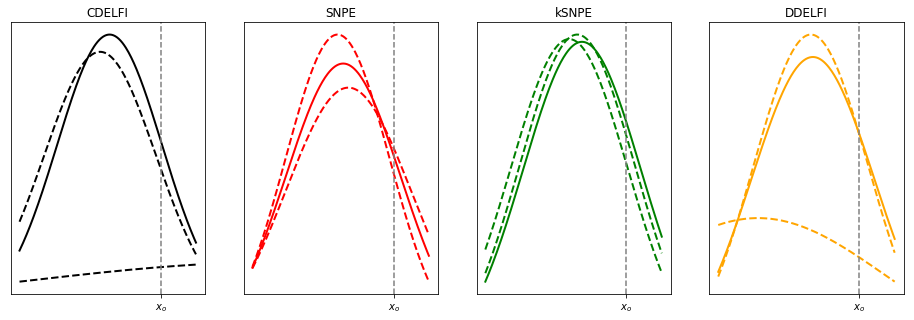

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41907501]: : 16it [00:00, 98.17it/s] 

loss=[ 2.40779734]: : 2007it [00:12, 165.54it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.45285511]: : 15it [00:00, 93.51it/s] 

loss=[ 2.45222688]: : 1080it [00:06, 158.92it/s]


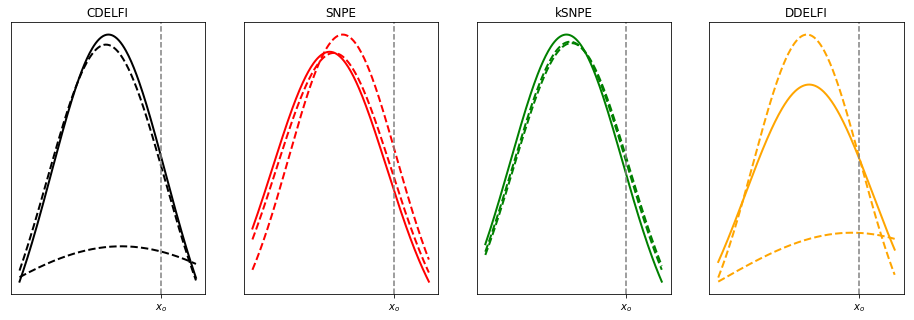

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42421532]: : 17it [00:00, 96.75it/s] 

loss=[ 2.416924]: : 1526it [00:09, 153.96it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43422627]: : 18it [00:00, 107.75it/s]

loss=[ 2.43420434]: : 1083it [00:06, 162.73it/s]


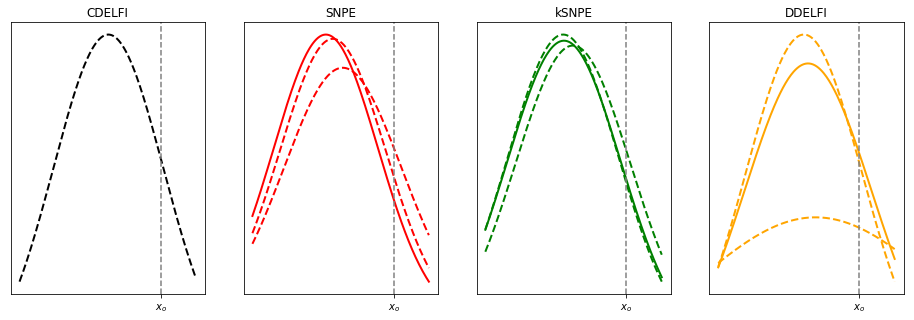

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41993046]: : 20it [00:00, 111.54it/s]

loss=[ 2.41241312]: : 1751it [00:09, 186.60it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41752911]: : 21it [00:00, 121.15it/s]

loss=[ 2.41751504]: : 1075it [00:05, 191.09it/s]


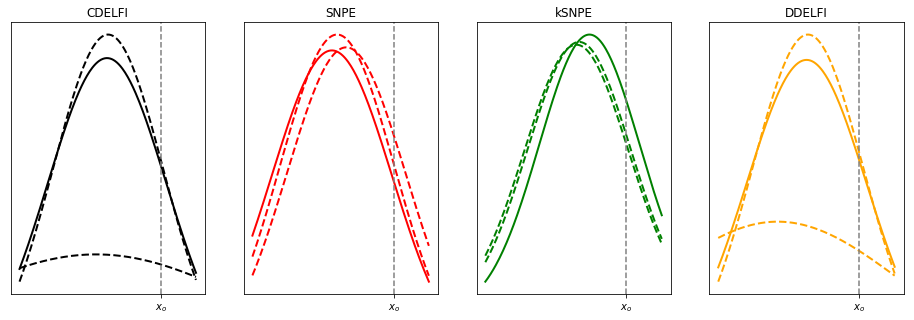

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.3990531]: : 19it [00:00, 103.86it/s] 

loss=[ 2.3930223]: : 1403it [00:07, 186.69it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41380477]: : 20it [00:00, 115.72it/s]

loss=[ 2.41375399]: : 996it [00:05, 184.93it/s]


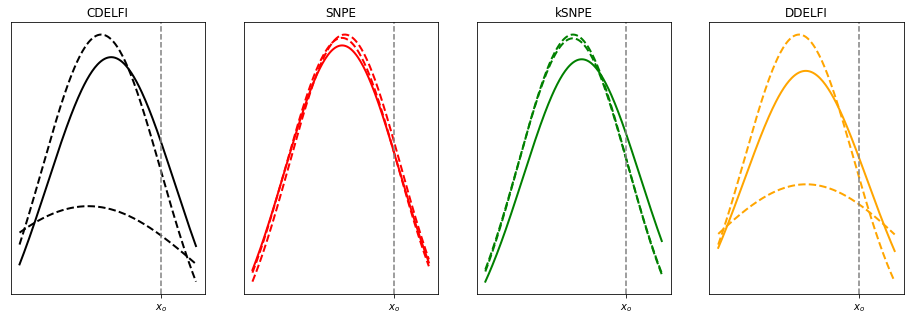

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.45280623]: : 20it [00:00, 110.52it/s]

loss=[ 2.44345808]: : 2816it [00:15, 183.43it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44249535]: : 17it [00:00, 114.80it/s]

loss=[ 2.44249344]: : 1046it [00:05, 176.83it/s]


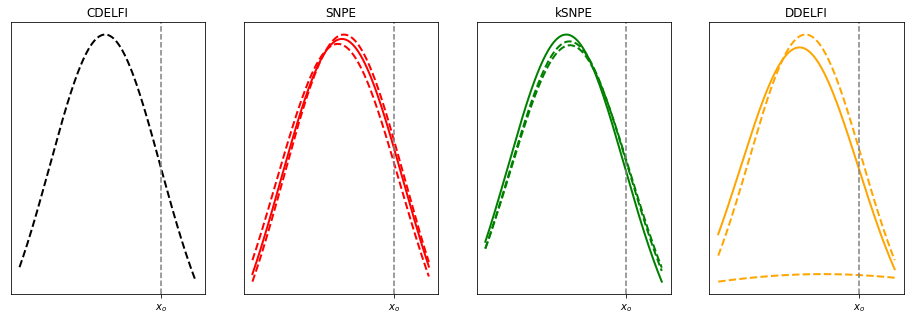

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41045094]: : 19it [00:00, 109.12it/s]

loss=[ 2.40259814]: : 1444it [00:09, 148.83it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4169507]: : 16it [00:00, 99.12it/s]  

loss=[ 2.41685128]: : 1032it [00:06, 159.08it/s]


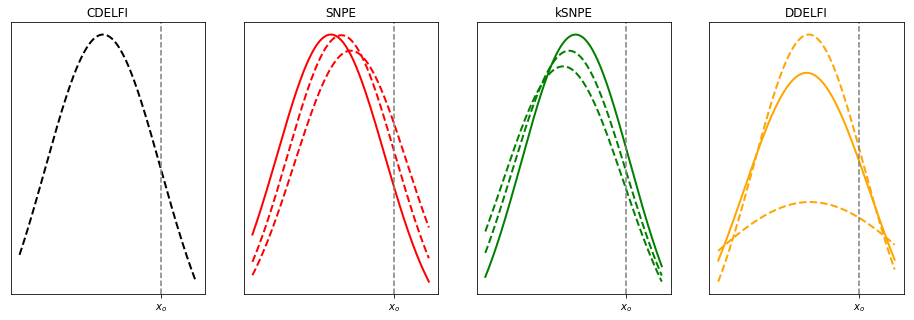

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43125129]: : 17it [00:00, 94.25it/s] 

loss=[ 2.4234271]: : 1671it [00:10, 156.03it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41337824]: : 20it [00:00, 116.46it/s]

loss=[ 2.41336989]: : 1063it [00:06, 166.29it/s]


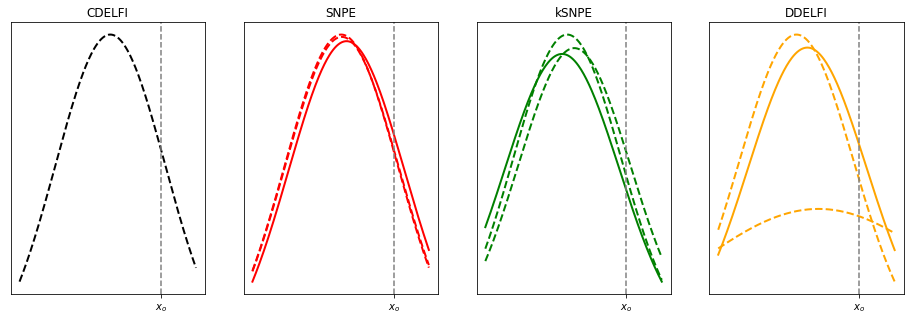

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42645097]: : 17it [00:00, 93.50it/s] 

loss=[ 2.41314507]: : 2904it [00:18, 159.50it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42751145]: : 17it [00:00, 103.05it/s]

loss=[ 2.42747068]: : 1019it [00:06, 160.81it/s]


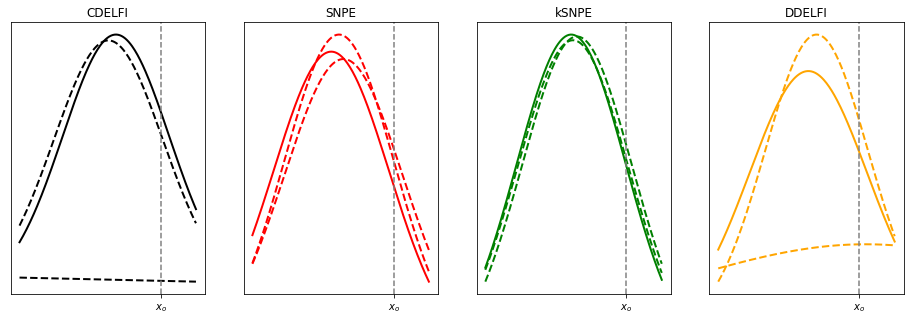

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4258759]: : 15it [00:00, 86.71it/s]  

loss=[ 2.4166131]: : 1532it [00:09, 158.25it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41545153]: : 14it [00:00, 84.19it/s] 

loss=[ 2.41532826]: : 1080it [00:07, 149.81it/s]


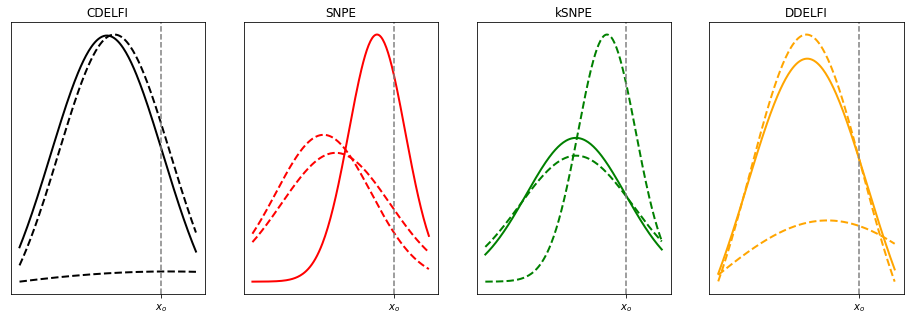

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41060567]: : 20it [00:00, 109.89it/s]

loss=[ 2.40170193]: : 1785it [00:09, 184.50it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42057586]: : 19it [00:00, 113.94it/s]

loss=[ 2.42055678]: : 1018it [00:05, 185.70it/s]


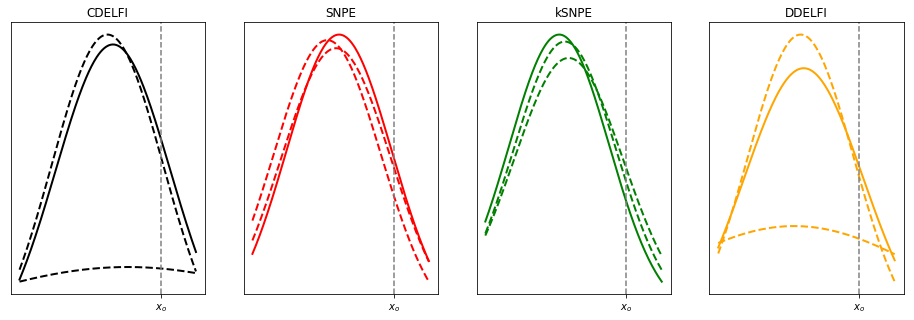

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43374705]: : 18it [00:00, 100.53it/s]

loss=[ 2.42528343]: : 2738it [00:15, 182.09it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4404521]: : 20it [00:00, 118.16it/s] 

loss=[ 2.43934274]: : 1092it [00:06, 181.83it/s]


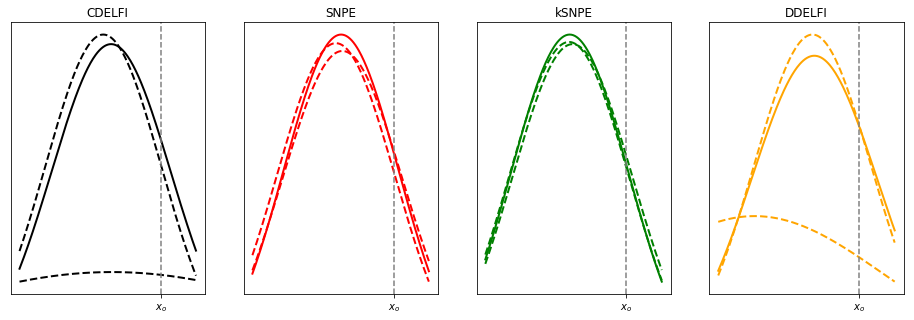

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44909263]: : 18it [00:00, 106.64it/s]

loss=[ 2.43730593]: : 3849it [00:25, 148.50it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43603253]: : 16it [00:00, 114.27it/s]

loss=[ 2.43602657]: : 1036it [00:06, 164.95it/s]


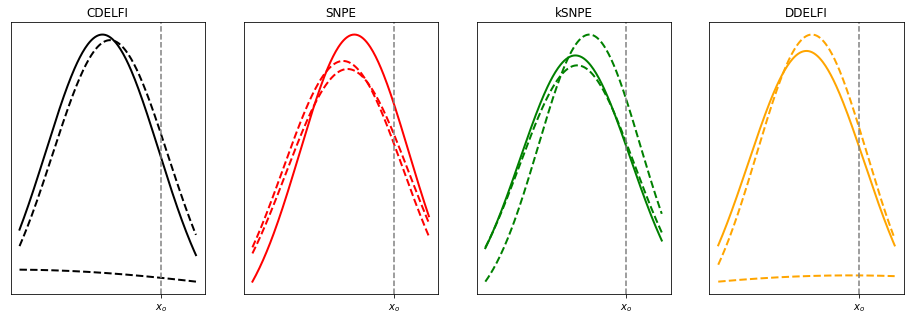

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.46930289]: : 17it [00:00, 97.70it/s] 

loss=[ 2.45892906]: : 2704it [00:16, 162.66it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.47521138]: : 15it [00:00, 104.61it/s]

loss=[ 2.47519183]: : 1052it [00:07, 141.66it/s]


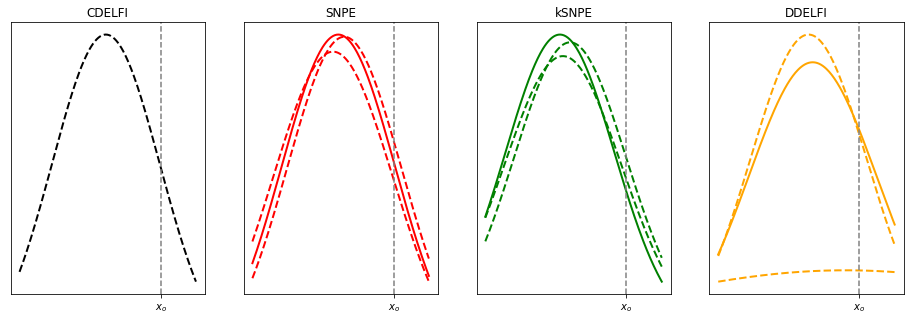

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41641259]: : 17it [00:00, 93.70it/s] 

loss=[ 2.40535927]: : 2153it [00:14, 148.74it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41048145]: : 19it [00:00, 112.73it/s]

loss=[ 2.41047907]: : 1061it [00:06, 159.92it/s]


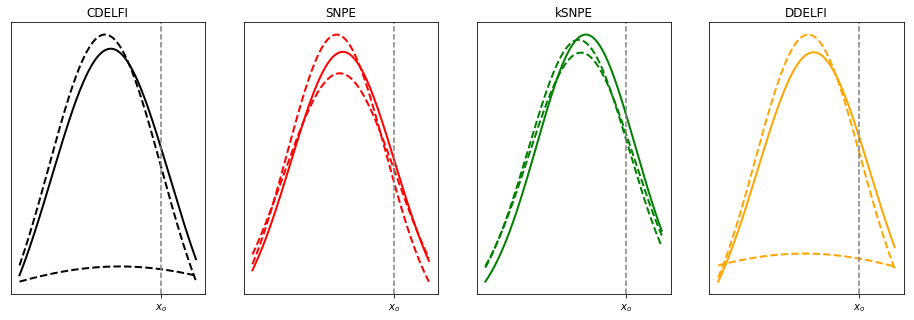

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44536448]: : 15it [00:00, 83.52it/s] 

loss=[ 2.43567991]: : 1851it [00:10, 171.65it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44128084]: : 19it [00:00, 113.56it/s]

loss=[ 2.4412694]: : 1059it [00:05, 181.21it/s]


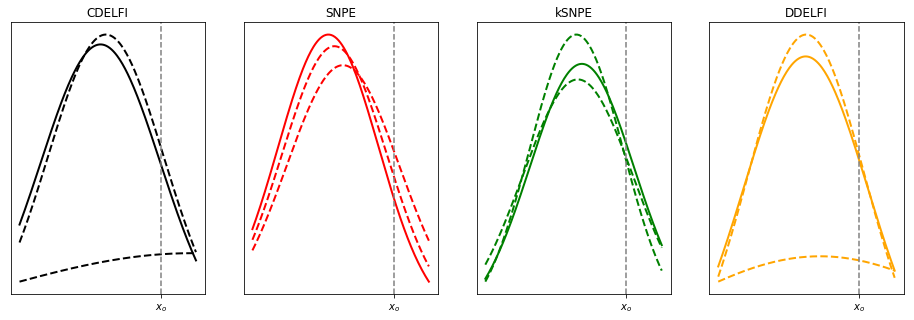

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43508172]: : 18it [00:00, 101.20it/s]

loss=[ 2.42606664]: : 2283it [00:14, 154.74it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42370129]: : 17it [00:00, 100.74it/s]

loss=[ 2.42367935]: : 1064it [00:06, 160.03it/s]


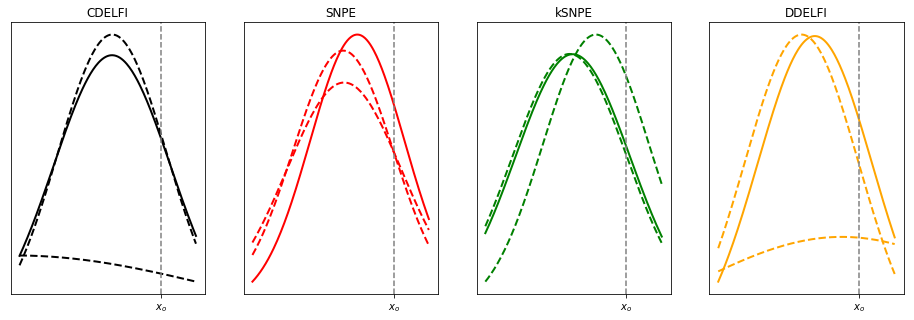

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4439826]: : 17it [00:00, 97.72it/s]  

loss=[ 2.43629837]: : 1701it [00:10, 162.91it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42174387]: : 15it [00:00, 95.14it/s] 

loss=[ 2.42173576]: : 1065it [00:07, 147.72it/s]


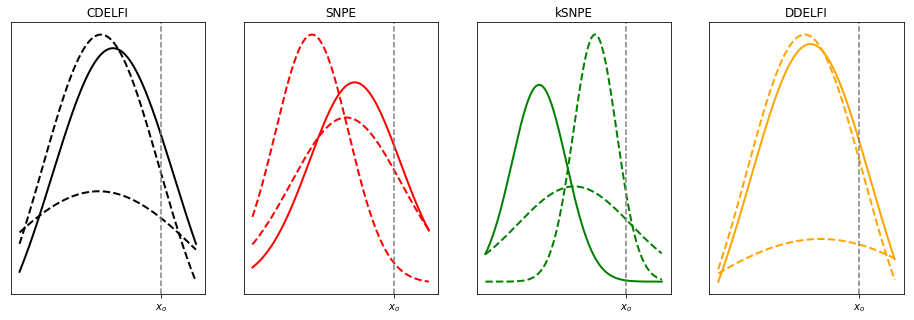

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42672634]: : 16it [00:00, 90.77it/s] 

loss=[ 2.42180037]: : 1315it [00:09, 135.77it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42494369]: : 16it [00:00, 94.70it/s] 

loss=[ 2.4248817]: : 1078it [00:06, 162.21it/s]


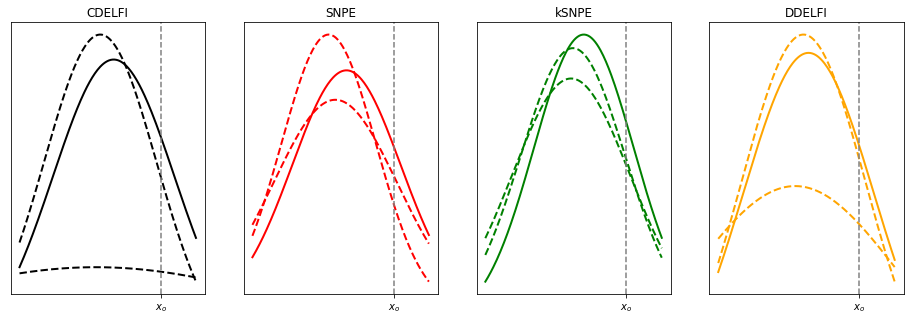

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43365383]: : 20it [00:00, 109.42it/s]

loss=[ 2.4239068]: : 2586it [00:14, 174.31it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42415786]: : 20it [00:00, 121.53it/s]

loss=[ 2.42413259]: : 1065it [00:05, 180.76it/s]


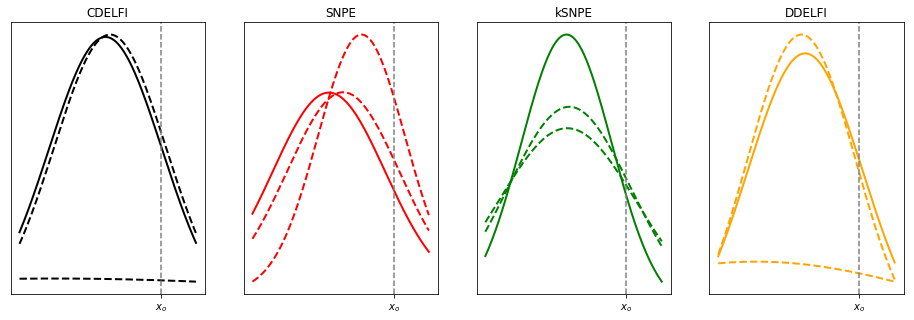

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42011619]: : 19it [00:00, 104.29it/s]

loss=[ 2.41297007]: : 1557it [00:08, 177.75it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.430305]: : 20it [00:00, 118.54it/s]  

loss=[ 2.43029714]: : 1071it [00:06, 178.18it/s]


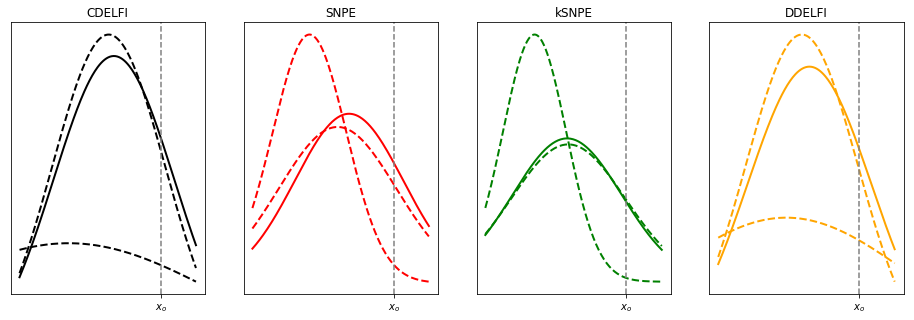

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42742991]: : 18it [00:00, 103.45it/s]

loss=[ 2.41937804]: : 1653it [00:12, 136.93it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44518232]: : 17it [00:00, 101.57it/s]

loss=[ 2.4451673]: : 1059it [00:07, 146.76it/s] 


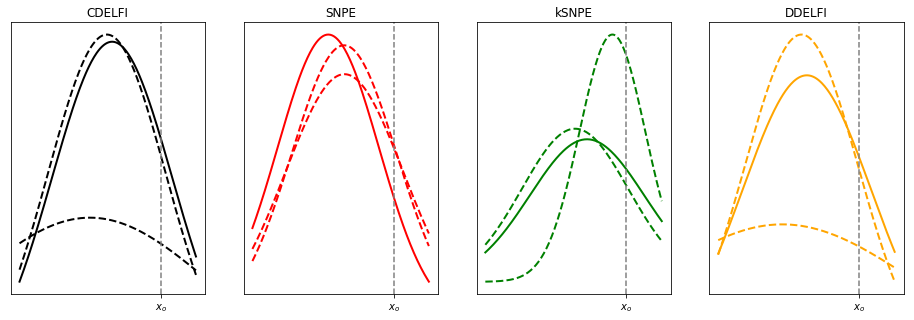

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42201114]: : 20it [00:00, 111.96it/s]

loss=[ 2.4149003]: : 1622it [00:09, 176.21it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40413308]: : 19it [00:00, 109.57it/s]

loss=[ 2.40395188]: : 1087it [00:06, 161.01it/s]


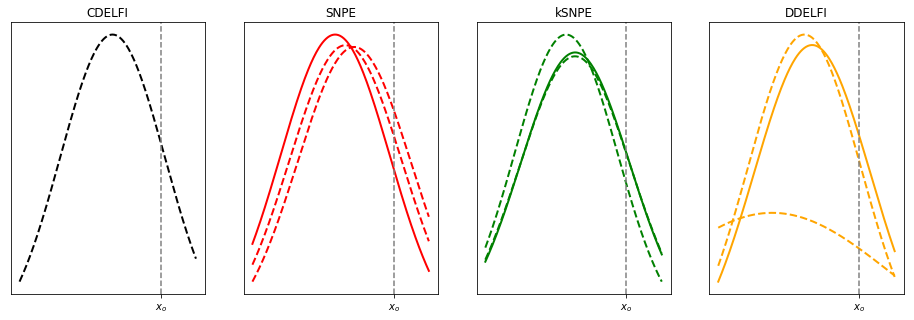

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.438519]: : 19it [00:00, 104.46it/s]  

loss=[ 2.42987347]: : 2147it [00:13, 163.26it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40771246]: : 19it [00:00, 113.66it/s]

loss=[ 2.40771055]: : 1038it [00:05, 180.47it/s]


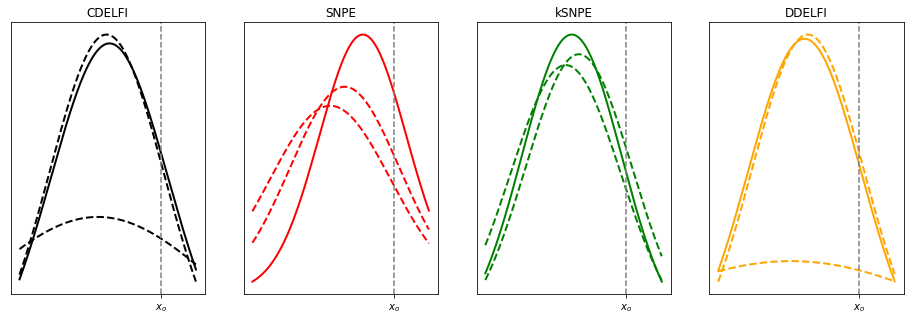

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.46347189]: : 20it [00:00, 110.75it/s]

loss=[ 2.45777512]: : 1647it [00:09, 172.23it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43504119]: : 19it [00:00, 113.63it/s]

loss=[ 2.43501496]: : 1060it [00:06, 173.70it/s]


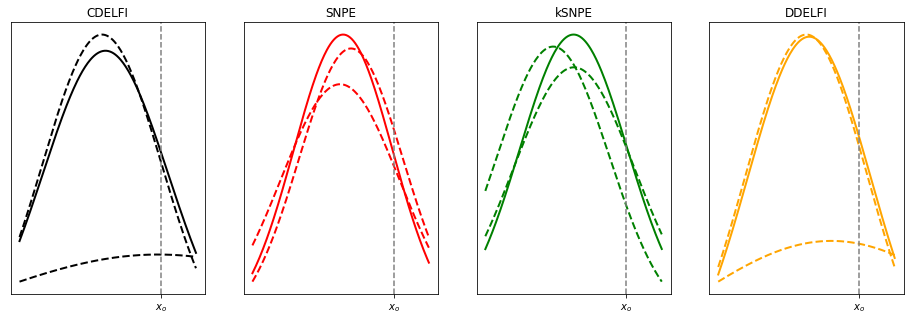

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43113613]: : 19it [00:00, 104.74it/s]

loss=[ 2.42186809]: : 2074it [00:12, 169.93it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43670535]: : 17it [00:00, 102.81it/s]

loss=[ 2.43667912]: : 1064it [00:06, 153.74it/s]


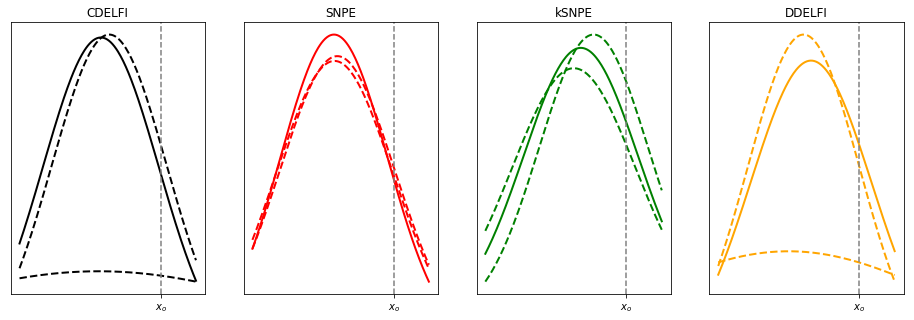

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43555784]: : 19it [00:00, 105.90it/s]

loss=[ 2.42634916]: : 2083it [00:12, 173.40it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40587997]: : 19it [00:00, 114.08it/s]

loss=[ 2.40587521]: : 1020it [00:05, 172.73it/s]


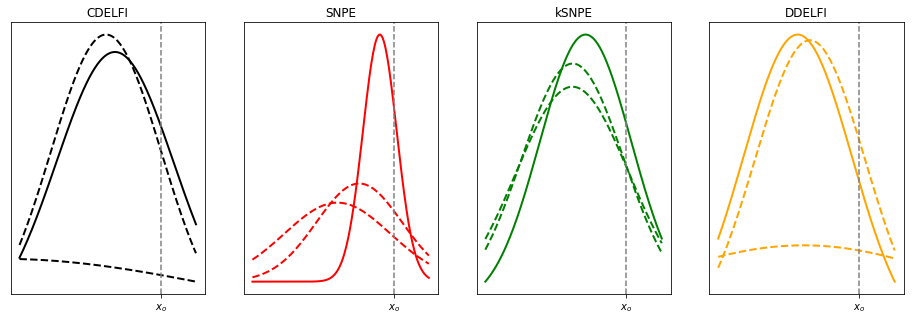

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4240551]: : 17it [00:00, 93.40it/s]  

loss=[ 2.41438103]: : 2018it [00:10, 199.39it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43217611]: : 21it [00:00, 125.09it/s]

loss=[ 2.43217468]: : 1025it [00:05, 200.10it/s]


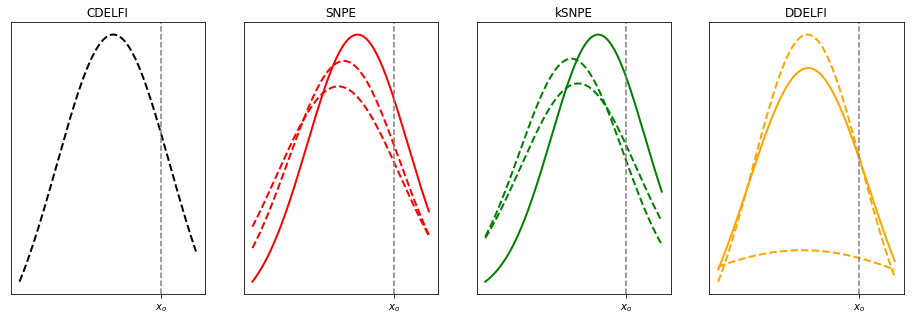

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41510224]: : 21it [00:00, 115.69it/s]

loss=[ 2.41017795]: : 1521it [00:07, 193.61it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42581415]: : 22it [00:00, 126.16it/s]

loss=[ 2.42580366]: : 1083it [00:05, 194.28it/s]


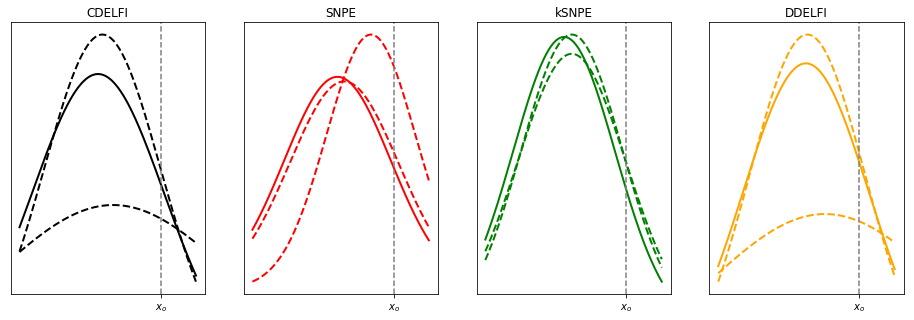

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41283941]: : 20it [00:00, 111.71it/s]

loss=[ 2.40514469]: : 1637it [00:09, 181.46it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41692543]: : 20it [00:00, 116.30it/s]

loss=[ 2.41692448]: : 1020it [00:05, 181.42it/s]


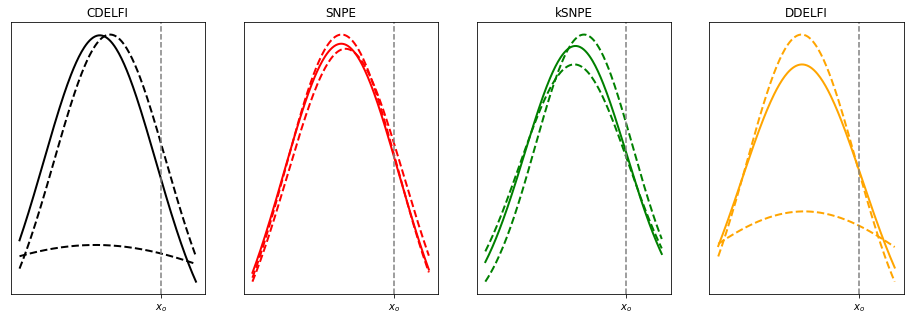

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44318628]: : 22it [00:00, 119.78it/s]

loss=[ 2.43798089]: : 1650it [00:08, 198.25it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44962478]: : 20it [00:00, 116.09it/s]

loss=[ 2.44961452]: : 1013it [00:05, 192.30it/s]


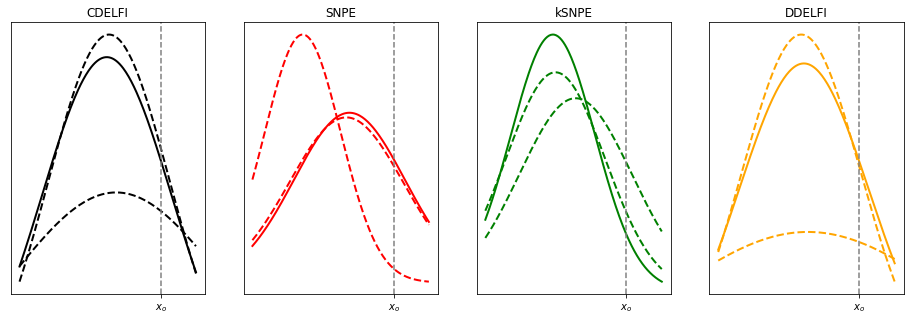

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40772915]: : 21it [00:00, 115.72it/s]

loss=[ 2.40480137]: : 1324it [00:07, 186.42it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43173862]: : 20it [00:00, 112.02it/s]

loss=[ 2.43096995]: : 1104it [00:05, 190.42it/s]


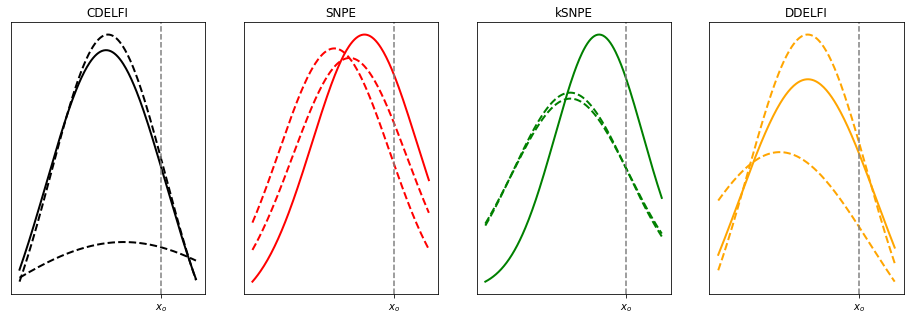

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40881634]: : 21it [00:00, 116.49it/s]

loss=[ 2.40244722]: : 1573it [00:07, 199.86it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41766024]: : 22it [00:00, 126.67it/s]

loss=[ 2.41763186]: : 1049it [00:05, 200.96it/s]


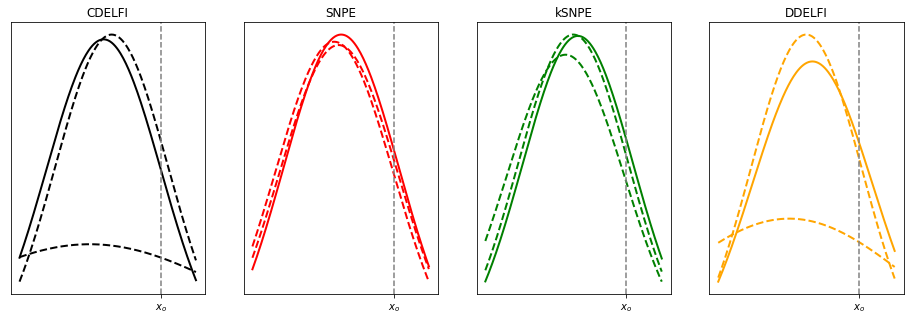

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.41319275]: : 22it [00:00, 119.66it/s]

loss=[ 2.40716028]: : 1748it [00:08, 203.18it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43536663]: : 22it [00:00, 127.13it/s]

loss=[ 2.43534565]: : 1064it [00:05, 199.88it/s]


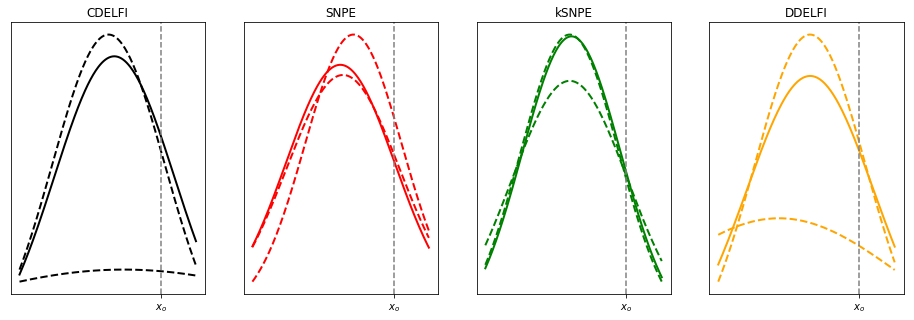

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.40904188]: : 22it [00:00, 119.56it/s]

loss=[ 2.4020412]: : 1820it [00:09, 185.56it/s] 


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.42320442]: : 22it [00:00, 125.66it/s]

loss=[ 2.42318702]: : 1070it [00:05, 179.36it/s]


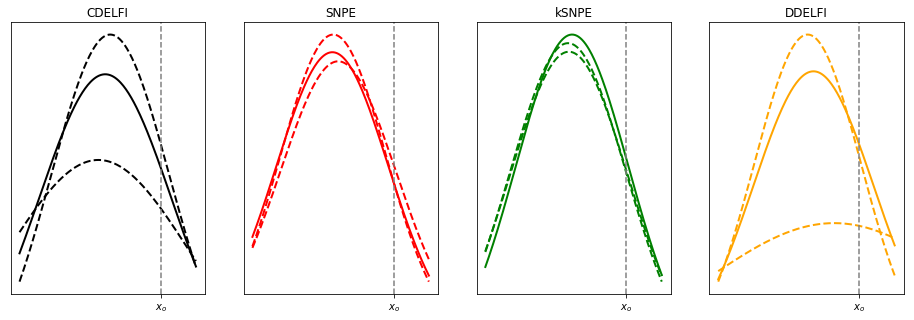

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4197402]: : 22it [00:00, 120.73it/s] 

loss=[ 2.41612291]: : 1363it [00:06, 203.26it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.43607473]: : 21it [00:00, 119.25it/s]

loss=[ 2.43604612]: : 1063it [00:05, 193.03it/s]


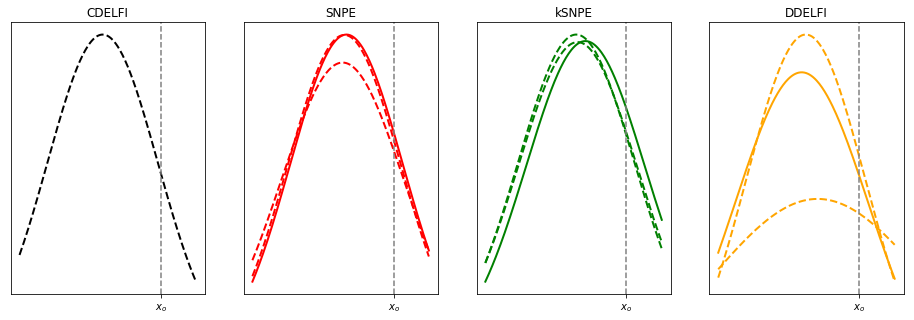

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


analytic correction for proposal seemingly failed!


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


re-initalizing network weights


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.4517529]: : 22it [00:00, 120.16it/s] 

loss=[ 2.44489431]: : 1949it [00:10, 189.18it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 2.44903708]: : 22it [00:00, 132.75it/s]

loss=[ 2.44903588]: : 1047it [00:05, 201.93it/s]


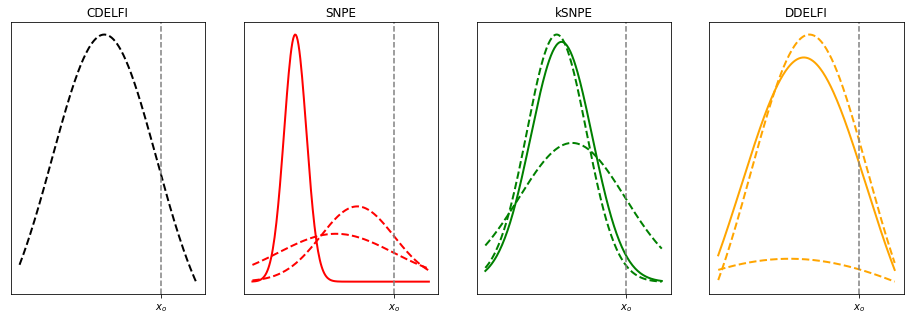

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [ ]:
std_params = params

algos = [ 'CDELFI', 'SNPE', 'kSNPE', 'DDELFI' ]
out = { algo : [] for algo in algos }

for r in range(params.n_runs):
    for algo in algos:
        out[algo].append(run_panel(algo, params, seed=params.seed + r))
        
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r in range(params.n_runs):
    plot_row({ algo : out[algo][-1] for algo in algos })

In [ ]:
for r, posterior in enumerate(posteriors[0:]):
    plot_pdf(posterior, 
             lims=[-params.prior_width,params.prior_width],  
             pdf2=params.gt,
             gt=params.true_params, 
             figsize=(9,9));

In [ ]:
for pred in preds[1:]:
    lhs = multiply_dists(pred['proposal'], pred['posterior'], (-params.prior_width * 5, params.prior_width * 5))
    rhs = multiply_dists(pred['prior'], pred['qphi'], (-params.prior_width * 5, params.prior_width * 5))
    
    plot_pdf(lhs, 
             pdf2 = rhs,
             lims=[-params.prior_width,params.prior_width],  
             figsize=(9,9));

In [ ]:
pred = preds[-1]

trainer = MoGTrainer(prop=pred['proposal'], 
                     prior=pred['prior'], 
                     qphi=pred['qphi'], 
                     n_components=params.n_comps, 
                     nsamples=10000)
            
trainer.train(nsteps=-1)
            
posterior = trainer.get_mog()

In [ ]:
plot_pdf(posterior, 
         pdf2 = params.gt,
         lims=[-params.prior_width,params.prior_width],  
         gt=params.true_params, 
         figsize=(9,9));